# Эксперименты с Tesseract 5 по распознаванию удостоверений на тестовой выборке

In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
!pip install python-Levenshtein tqdm opencv-python-headless -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.9 MB/s eta 0:00:00


## Оценка работы на тестовом датасете

In [ ]:
import os

JSON_PATH = '/content/drive/MyDrive/VKR/kpk_dataset-9/test_annotations.json'

if not os.path.exists(JSON_PATH):
    print(f"Файл не найден: {JSON_PATH}")
    print("Доступные файлы в директории:")
    print(os.listdir('/content/drive/MyDrive/VKR/kpk_dataset-9/'))
else:
    print("Файл найден, можно продолжать")

Файл найден, можно продолжать


In [ ]:
# Импорт библиотек
import os
import cv2
import json
import easyocr
import pandas as pd
import numpy as np
from Levenshtein import distance as levenshtein_distance
from openpyxl import Workbook
from openpyxl.drawing.image import Image as ExcelImage
from PIL import Image as PILImage
import io

In [ ]:
def preprocess_image(image, method='clahe'):
    """
    Предобработка изображения с различными методами

    Параметры:
    - image: входное изображение (BGR или grayscale)
    - method: метод предобработки:
      'none': без обработки (только grayscale)
      'median': медианный фильтр
      'otsu': метод Оцу
      'adaptive': адаптивная бинаризация
      'morph': морфологическая обработка
      'sharpen': увеличение резкости
      'otsu_morph': Оцу + морф. обработка
      'combo': Gaussian blur + Otsu + Sauvola
      'clahe': контрастное ограничение
    """
    # Конвертация в grayscale (если нужно)
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    if method == 'none':
        return gray

    elif method == 'median':
        return cv2.medianBlur(gray, 3)

    elif method == 'otsu':
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thresh

    elif method == 'adaptive':
        return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 17, 0)

    elif method == 'morph':
        kernel = np.ones((2, 2), np.uint8)
        morph = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
        return morph

    elif method == 'sharpen':
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        return cv2.filter2D(gray, -1, kernel)

    elif method == 'otsu_morph':
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        return cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    elif method == 'combo':
        blur = cv2.GaussianBlur(gray, (3, 3), 0)
        _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        sauvola = cv2.ximgproc.niBlackThreshold(blur, maxValue=255, type=cv2.THRESH_BINARY,
                                              blockSize=11, k=0.1, binarizationMethod=cv2.ximgproc.BINARIZATION_SAUVOLA)
        return cv2.bitwise_and(otsu, sauvola)

    elif method == 'clahe':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(gray)

    else:
        raise ValueError(f"Unknown method: {method}")

In [ ]:
# Настройки путей
IMAGES_DIR = '/content/drive/MyDrive/VKR/kpk_dataset-9/test/images'
LABELS_DIR = '/content/drive/MyDrive/VKR/kpk_dataset-9/test/labels'
JSON_PATH = '/content/drive/MyDrive/VKR/kpk_dataset-9/test_annotations.json'
EXCEL_PATH = '/content/drive/MyDrive/VKR/results/results_easyocr.xlsx'  # Изменяем имя файла
DEBUG_DIR = '/content/drive/MyDrive/VKR/results/debug_images'
TEMP_IMG_DIR = '/content/drive/MyDrive/VKR/results/temp_images_easyocr'  # Изменяем временную директорию
os.makedirs(DEBUG_DIR, exist_ok=True)
os.makedirs(TEMP_IMG_DIR, exist_ok=True)

# Классы
CLASS_MAPPING = {
    0: "city",
    1: "course_period",
    2: "course_topic",
    3: "hours",
    4: "name",
    5: "organization",
    6: "registration_number",
    7: "year"
}

def load_annotations(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return {os.path.splitext(item['file_name'])[0]: item['annotations'] for item in data['images']}

def read_yolo_bboxes(label_path, img_width, img_height):
    if not os.path.exists(label_path):
        return []

    bboxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id, x_center, y_center, width, height = map(float, parts)
            x1 = int((x_center - width/2) * img_width)
            y1 = int((y_center - height/2) * img_height)
            x2 = int((x_center + width/2) * img_width)
            y2 = int((y_center + height/2) * img_height)
            bboxes.append((int(class_id), (x1, y1, x2, y2)))
    return bboxes

def clean_text(text):
    return ' '.join(text.replace('\n', ' ').replace('\r', ' ').split()).strip()

def save_image_to_temp(image, filename):
    """Сохраняет изображение во временную директорию и возвращает путь."""
    temp_path = os.path.join(TEMP_IMG_DIR, filename)
    cv2.imwrite(temp_path, image)
    return temp_path

def process_image_with_stats(image_path, label_path, annotations, debug=False):
    image = cv2.imread(image_path)
    if image is None:
        return []

    image_id = os.path.splitext(os.path.basename(image_path))[0]
    img_height, img_width = image.shape[:2]
    bboxes = read_yolo_bboxes(label_path, img_width, img_height)

    # Инициализация EasyOCR reader (русский и английский языки)
    reader = easyocr.Reader(['ru', 'en'])

    results = []
    for i, (class_id, bbox) in enumerate(bboxes):
        field_name = CLASS_MAPPING.get(class_id, f"Class {class_id}")
        cropped = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

        # Сохраняем изображение до обработки
        original_img_path = save_image_to_temp(cropped, f"{image_id}_{i}_original.png")

        # Обработка изображения
        processed = preprocess_image(cropped)

        # Сохраняем изображение после обработки
        processed_img_path = save_image_to_temp(processed, f"{image_id}_{i}_processed.png")

        # Распознавание с помощью EasyOCR
        # Указываем detail=0 чтобы получить только текст
        recognition_results = reader.readtext(processed, detail=0)
        recognized_text = clean_text(' '.join(recognition_results))

        reference_text = clean_text(annotations.get(image_id, {}).get(field_name, ""))
        cer = calculate_cer(reference_text, recognized_text)

        results.append({
            "image_id": image_id,
            "class": field_name,
            "reference": reference_text,
            "recognized": recognized_text,
            "cer": cer,
            "original_image": original_img_path,
            "processed_image": processed_img_path
        })

    return results

def calculate_cer(reference, hypothesis):
    if not reference:
        return 0.0 if not hypothesis else 1.0
    return levenshtein_distance(reference, hypothesis) / max(len(reference), 1)

def main():
    annotations = load_annotations(JSON_PATH)
    image_files = [f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    all_results = []
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(IMAGES_DIR, image_file)
        label_path = os.path.join(LABELS_DIR, os.path.splitext(image_file)[0] + ".txt")

        print(f"Обработка {i+1}/{len(image_files)}: {image_file}")
        results = process_image_with_stats(
            image_path, label_path, annotations,
            debug=(i < 3)
        )
        all_results.extend(results)

    # Создаем DataFrame
    df = pd.DataFrame(all_results)

    # Создаем Excel файл с изображениями
    wb = Workbook()
    ws = wb.active
    ws.title = "Results"

    # Заголовки
    headers = ["Image ID", "Class", "Reference Text", "Recognized Text", "CER", "Original Image", "Processed Image"]
    ws.append(headers)

    # Добавляем данные и изображения
    for idx, row in df.iterrows():
        ws.append([
            row["image_id"],
            row["class"],
            row["reference"],
            row["recognized"],
            row["cer"],
            "",  # Место для изображения
            ""   # Место для изображения
        ])

        # Добавляем оригинальное изображение
        if os.path.exists(row["original_image"]):
            img = ExcelImage(row["original_image"])
            img.width = 100
            img.height = 100
            ws.add_image(img, f'F{idx + 2}')

        # Добавляем обработанное изображение
        if os.path.exists(row["processed_image"]):
            img = ExcelImage(row["processed_image"])
            img.width = 100
            img.height = 100
            ws.add_image(img, f'G{idx + 2}')

    # Сохраняем Excel файл
    wb.save(EXCEL_PATH)

    # Анализ результатов
    print("\nОбщая статистика CER:")
    print(f"Средний: {df['cer'].mean():.4f}")
    print(f"Медиана: {df['cer'].median():.4f}")

    print("\nПо классам:")
    print(df.groupby('class')['cer'].mean().sort_values())

    print(f"\nРезультаты сохранены в {EXCEL_PATH}")

if __name__ == "__main__":
    main()

Обработка 1/115: kpk_459_page_1_png.rf.766d830189918fa629196a61170345e3.jpg


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% CompleteОбработка 2/115: kpk_461_page_1_png.rf.8289dd47c78f89e8342e49f3261112bd.jpg
Обработка 3/115: kpkimg_1001_png.rf.1945e6916a6a5a5af678ae63f710787e.jpg
Обработка 4/115: kpkimg_1005_png.rf.b1eeb8a03a503069499a3e9aab09b8fb.jpg
Обработка 5/115: kpkimg_1014_png.rf.77bea6336c12bbdccdae3a2b24d0f64a.jpg
Обработка 6/115: kpkimg_1022_png.rf.6824e4c497232cebe8bb6a861e8c514d.jpg
Обработка 7/115: kpkimg_1023_png.rf.90f5271ffc8e01cab9ba142fe41b640c.jpg
Обработка 8/115: kpkimg_1050_png.rf.555de1f3c220972aace660f40c342968.jpg
Обработка 9/115: kpkimg_1051_png.rf.c286cc17cf1d479931131741a64f3e05.jpg
Обработка 10/115: kpkimg_1056_png.rf.d5df2c422b74c1377d0f0ced12080a6f.jpg
Обработка 11/115: kpkimg_1057_png.rf.bf26ed59e8bc36662a0ce747e7b345be.jpg
Обработка 12/115: kpkimg_139_png.rf.bc6630a2cb710a876d74da2e15e51f14.jpg
Обработка 13/115: kpkimg_140_png.rf.305ee85bc9d84f04448d5a738181ea9e.jpg
Обработка 14/115: kpkimg_147_png.rf.b27ee

## Оценка времени работы

In [ ]:
# Импорт библиотек
import time
import cv2
import os
import pandas as pd
import easyocr
from tqdm import tqdm
import json
from Levenshtein import distance as levenshtein_distance

# Конфигурация
IMAGES_DIR = '/content/drive/MyDrive/VKR/kpk_dataset-9/test/images'
LABELS_DIR = '/content/drive/MyDrive/VKR/kpk_dataset-9/test/labels'
JSON_PATH = '/content/drive/MyDrive/VKR/kpk_dataset-9/test_annotations.json'
RESULTS_DIR = '/content/drive/MyDrive/VKR/results/easyocr'
os.makedirs(RESULTS_DIR, exist_ok=True)

CLASS_MAPPING = {
    0: "city",
    1: "course_period",
    2: "course_topic",
    3: "hours",
    4: "name",
    5: "organization",
    6: "registration_number",
    7: "year"
}

def load_annotations(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return {os.path.splitext(item['file_name'])[0]: item['annotations'] for item in data['images']}

def read_yolo_bboxes(label_path, img_width, img_height):
    if not os.path.exists(label_path):
        return []
    bboxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id, x_center, y_center, width, height = map(float, parts)
            x1 = int((x_center - width/2) * img_width)
            y1 = int((y_center - height/2) * img_height)
            x2 = int((x_center + width/2) * img_width)
            y2 = int((y_center + height/2) * img_height)
            bboxes.append((int(class_id), (x1, y1, x2, y2)))
    return bboxes

def process_image_easyocr(image_path, label_path, annotations, reader):
    image = cv2.imread(image_path)
    if image is None:
        return []

    image_id = os.path.splitext(os.path.basename(image_path))[0]
    img_height, img_width = image.shape[:2]
    bboxes = read_yolo_bboxes(label_path, img_width, img_height)

    results = []
    for class_id, bbox in bboxes:
        field_name = CLASS_MAPPING.get(class_id, f"Class {class_id}")
        cropped = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

        # Предобработка
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

        # Замер времени
        start_time = time.time()
        recognition_results = reader.readtext(gray, detail=0)
        elapsed = time.time() - start_time

        recognized_text = ' '.join(recognition_results).strip()
        reference_text = annotations.get(image_id, {}).get(field_name, "")

        results.append({
            'image_id': image_id,
            'class': field_name,
            'time': elapsed,
            'cer': levenshtein_distance(reference_text, recognized_text) / max(len(reference_text), 1)
        })

    return results

def main_easyocr():
    annotations = load_annotations(JSON_PATH)
    image_files = [f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Начато тестирование EasyOCR на {len(image_files)} изображениях")

    # Инициализация EasyOCR один раз
    reader = easyocr.Reader(['ru', 'en'])

    all_results = []
    for img_file in tqdm(image_files):
        image_path = os.path.join(IMAGES_DIR, img_file)
        label_path = os.path.join(LABELS_DIR, os.path.splitext(img_file)[0] + ".txt")

        results = process_image_easyocr(image_path, label_path, annotations, reader)
        all_results.extend(results)

    # Сохранение и анализ результатов
    df = pd.DataFrame(all_results)
    df.to_csv(os.path.join(RESULTS_DIR, 'easyocr_results.csv'), index=False)

    print("\nРезультаты EasyOCR:")
    print(f"Общее время: {df['time'].sum():.2f} сек")
    print(f"Среднее время: {df['time'].mean():.4f} сек/изображение")
    print(f"Средний CER: {df['cer'].mean():.4f}")

if __name__ == "__main__":
    main_easyocr()

Начато тестирование EasyOCR на 115 изображениях


100%|██████████| 115/115 [06:04<00:00,  3.17s/it]


Результаты EasyOCR:
Общее время: 362.13 сек
Среднее время: 0.3993 сек/изображение
Средний CER: 0.0804


## Интервальная оценка CER для easyocr

In [ ]:
# Импорт библиотек
import numpy as np
from scipy import stats

RESULTS_DIR = '/content/drive/MyDrive/VKR/results/easyocr'

def calculate_confidence_interval_easyocr():
    # Загрузка результатов
    df = pd.read_csv(os.path.join(RESULTS_DIR, 'easyocr_results.csv'))

    # Удаление нулевых строк (если есть проблемы с данными)
    df = df[df['cer'].notna()]

    # Расчет параметров
    mean_cer = df['cer'].mean()
    std_cer = df['cer'].std()
    n = len(df)

    # 95% доверительный интервал
    confidence = 0.95
    se = std_cer / np.sqrt(n)
    ci = stats.t.interval(confidence, n-1, loc=mean_cer, scale=se)

    print("\nИнтервальная оценка CER для EasyOCR:")
    print(f"Средний CER: {mean_cer:.4f}")
    print(f"Стандартное отклонение: {std_cer:.4f}")
    print(f"95% доверительный интервал: ({ci[0]:.4f}, {ci[1]:.4f})")
    print(f"Количество образцов: {n}")

if __name__ == "__main__":
    calculate_confidence_interval_easyocr()


Интервальная оценка CER для EasyOCR:
Средний CER: 0.0804
Стандартное отклонение: 0.1355
95% доверительный интервал: (0.0715, 0.0892)
Количество образцов: 907


## Визуализация и сравнение интервальных оценок CER для Tesseract и EasyOCR

<ipython-input-7-898822851b43>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='OCR', y='cer', data=combined_df, palette=palette, width=0.4)


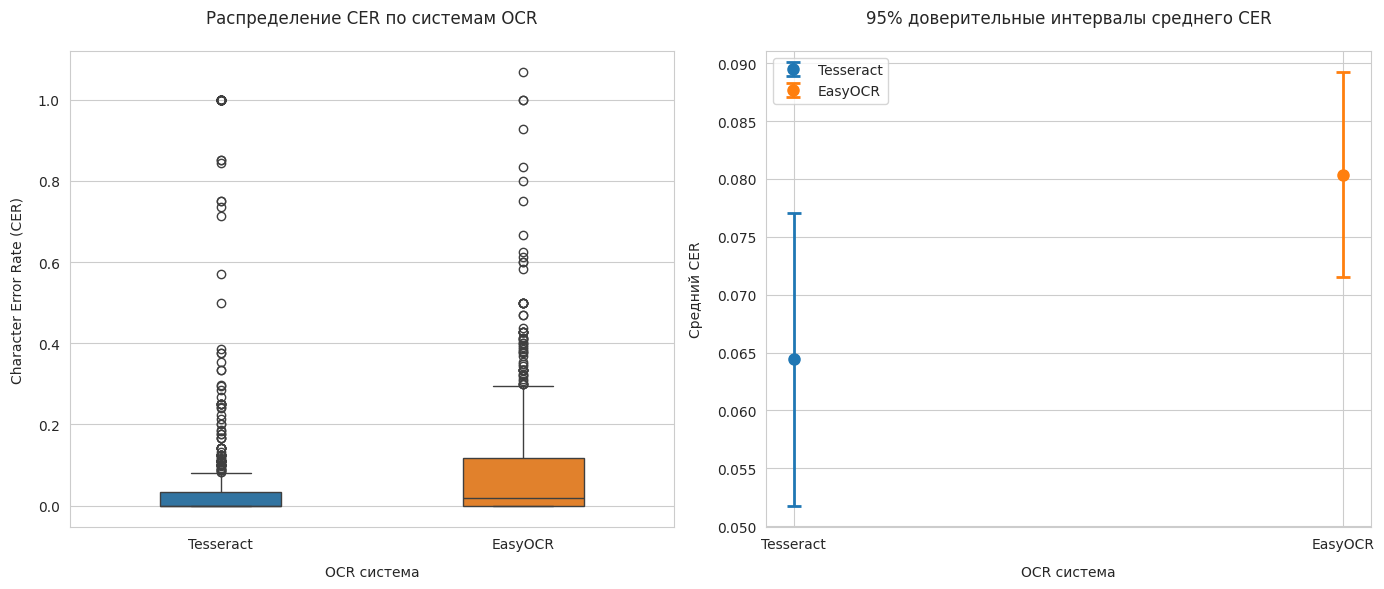


Сравнительный анализ OCR систем:
--------------------------------------------------
Метрика                  Tesseract      EasyOCR        
--------------------------------------------------
mean                     0.0644         0.0804         
std                      0.1942         0.1355         
ci_lower                 0.0518         0.0715         
ci_upper                 0.0771         0.0892         
n                        907.0000       907.0000       

Анализ доверительных интервалов:
Доверительные интервалы перекрываются - разница может быть не значима

Результаты сохранены в: /content/drive/MyDrive/VKR/results/comparison


In [ ]:
# Импорт библиотек
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Пути к данным
TESTSERACT_PATH = '/content/drive/MyDrive/VKR/results/tesseract/tesseract_results.csv'
EASYOCR_PATH = '/content/drive/MyDrive/VKR/results/easyocr/easyocr_results.csv'
OUTPUT_DIR = '/content/drive/MyDrive/VKR/results/comparison'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_and_prepare_data():
    """Загрузка и подготовка данных для анализа"""
    # Загрузка данных
    tesseract_df = pd.read_csv(TESTSERACT_PATH)
    easyocr_df = pd.read_csv(EASYOCR_PATH)

    # Добавление идентификатора OCR системы
    tesseract_df = tesseract_df[['cer']].assign(OCR='Tesseract')
    easyocr_df = easyocr_df[['cer']].assign(OCR='EasyOCR')

    # Объединение данных
    combined_df = pd.concat([tesseract_df, easyocr_df], ignore_index=True)
    return combined_df

def calculate_statistics():
    """Расчет статистических показателей и доверительных интервалов"""
    # Загрузка данных
    tesseract_df = pd.read_csv(TESTSERACT_PATH)
    easyocr_df = pd.read_csv(EASYOCR_PATH)

    # Функция для расчета статистик
    def get_stats(df, name):
        df = df[df['cer'].notna()]
        mean = df['cer'].mean()
        std = df['cer'].std()
        n = len(df)
        se = std / np.sqrt(n)
        ci = stats.t.interval(0.95, n-1, loc=mean, scale=se)
        return {
            'OCR': name,
            'mean': mean,
            'std': std,
            'n': n,
            'ci_lower': ci[0],
            'ci_upper': ci[1]
        }

    # Расчет для обоих OCR
    stats_tesseract = get_stats(tesseract_df, 'Tesseract')
    stats_easyocr = get_stats(easyocr_df, 'EasyOCR')

    return pd.DataFrame([stats_tesseract, stats_easyocr])

def plot_comparison(combined_df, stats_df):
    """Визуализация сравнения OCR систем"""
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")
    palette = {"Tesseract": "#1f77b4", "EasyOCR": "#ff7f0e"}

    # 1. Boxplot распределений CER
    plt.subplot(1, 2, 1)
    sns.boxplot(x='OCR', y='cer', data=combined_df, palette=palette, width=0.4)
    plt.title('Распределение CER по системам OCR', pad=20)
    plt.ylabel('Character Error Rate (CER)', labelpad=10)
    plt.xlabel('OCR система', labelpad=10)

    # 2. Доверительные интервалы среднего
    plt.subplot(1, 2, 2)
    for _, row in stats_df.iterrows():
        plt.errorbar(x=row['OCR'], y=row['mean'],
                    yerr=[[row['mean'] - row['ci_lower']], [row['ci_upper'] - row['mean']]],
                    fmt='o', capsize=5, capthick=2, elinewidth=2,
                    color=palette[row['OCR']], markersize=8, label=row['OCR'])

    plt.title('95% доверительные интервалы среднего CER', pad=20)
    plt.ylabel('Средний CER', labelpad=10)
    plt.xlabel('OCR система', labelpad=10)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'cer_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

def print_statistical_comparison(stats_df):
    """Вывод статистического сравнения"""
    print("\nСравнительный анализ OCR систем:")
    print("-" * 50)
    print(f"{'Метрика':<25}{'Tesseract':<15}{'EasyOCR':<15}")
    print("-" * 50)

    for metric in ['mean', 'std', 'ci_lower', 'ci_upper', 'n']:
        t_val = stats_df.loc[stats_df['OCR'] == 'Tesseract', metric].values[0]
        e_val = stats_df.loc[stats_df['OCR'] == 'EasyOCR', metric].values[0]
        print(f"{metric:<25}{t_val:<15.4f}{e_val:<15.4f}")

    # Проверка перекрытия интервалов
    t_ci = (stats_df.loc[stats_df['OCR'] == 'Tesseract', 'ci_lower'].values[0],
            stats_df.loc[stats_df['OCR'] == 'Tesseract', 'ci_upper'].values[0])
    e_ci = (stats_df.loc[stats_df['OCR'] == 'EasyOCR', 'ci_lower'].values[0],
            stats_df.loc[stats_df['OCR'] == 'EasyOCR', 'ci_upper'].values[0])

    print("\nАнализ доверительных интервалов:")
    if t_ci[1] < e_ci[0] or e_ci[1] < t_ci[0]:
        print("Доверительные интервалы НЕ перекрываются - разница статистически значима")
    else:
        print("Доверительные интервалы перекрываются - разница может быть не значима")

def main():
    # Загрузка и подготовка данных
    combined_df = load_and_prepare_data()

    # Расчет статистик
    stats_df = calculate_statistics()

    # Визуализация
    plot_comparison(combined_df, stats_df)

    # Вывод результатов
    print_statistical_comparison(stats_df)

    # Сохранение статистик
    stats_df.to_csv(os.path.join(OUTPUT_DIR, 'ocr_stats_comparison.csv'), index=False)
    print(f"\nРезультаты сохранены в: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()